In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import norm
import statsmodels.api as sm
import re
import calendar

import matplotlib.pyplot as plt
import seaborn as sns

import copy

%matplotlib inline
%load_ext autotime

time: 287 µs (started: 2022-11-10 23:16:40 -05:00)


In [2]:
# Enrollment numbers
# https://infohub.nyced.org/reports/school-quality/information-and-data-overview
enrollment_count = {
    2017: 1135334,
    2018: 1126501,
    2019: 1131868,
    2020: 1094138,
    2021: 1058888,
    2022: 1058888*.982 #This is an based on the 1.8% drop in school population from last year.
}

time: 512 µs (started: 2022-11-10 23:16:40 -05:00)


In [3]:
pull_from_api = False
if (pull_from_api):
    data_orig = pd.read_json("https://data.cityofnewyork.us/resource/ez4e-fazm.json?$limit=99999999")
    data_orig['occurred_on'] = pd.to_datetime(data_orig['occurred_on'])
else:
    data_orig = pd.read_csv("../data/input/raw/Bus_Breakdown_and_Delays.csv", parse_dates = [7])

/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/3086854128.py:6: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data_orig = pd.read_csv("../data/input/raw/Bus_Breakdown_and_Delays.csv", parse_dates = [7])


time: 22.4 s (started: 2022-11-10 23:16:40 -05:00)


In [4]:
def clean_delay_times(x):
    a = x
    x = str(x).lower().rstrip().replace('1 1/2', '1 2').replace('11/2', '1 2').\
    replace('1/2', '0 1').replace('half', '0 1').replace('to', '-')
    units = re.findall(r'[a-z ]+', x)
    time = re.split(r'[- /,]', ''.join(re.findall(r'[0-9 .,/-]+', x)) )
    time = [i for i in time if not((re.search('[.]+',i) !=None)|(re.search('[ ]+',i) !=None)|(i==''))]
    if time:
        time = np.nanmean([float(i) for i in time])
    else:
        time = 0
    
    if any(i in ''.join(units) for i in ['h', 'r']) and ( time <= 5 ):
#         print(a)
#         print(time*60)
        return time*60
    elif any(i in ''.join(units) for i in ['m', 'n']) | (x == ''):
        return time
    else:
#         print(a)
#         print(time, units)
        return 0

time: 1.15 ms (started: 2022-11-10 23:17:02 -05:00)


In [5]:
# Drop the 2020 data point
# data_orig.drop(data_orig[data_orig['School_Year'] == '2019-2020'].index, inplace = True)
data_orig['delay_time'] = data_orig.How_Long_Delayed.astype(str).apply(clean_delay_times)
# Only can normalize from 2017 forth.
data_orig = data_orig[(data_orig['Occurred_On'] >= pd.to_datetime('09-7-2017')) & 
                      (data_orig['Occurred_On'] < pd.to_datetime('11-1-2022'))]

time: 20.9 s (started: 2022-11-10 23:17:02 -05:00)


In [6]:
# Filter out off days and weekends

days_closed = pd.read_csv('../data/output/school_calendar_dates.csv', 
                          parse_dates = ['Start Date', 'End Date']).drop(columns = ['Unnamed: 0'])
days_closed = days_closed[days_closed['Closure'] == 1]

# def off_day(i):
#     return days_closed.apply(lambda x: (i >= x['Start Date']) & (i <= x['End Date'] + pd.DateOffset(1) ) ,axis = 1).any()

# data_orig = data_orig[data_orig['Occurred_On'].apply(off_day)] # Take ~25 minutes to run.......

###########Faster Version####################
data_orig['closed'] = 1

for row, val in days_closed.iterrows():
    a = val['Start Date']
    b = val['End Date'] + pd.DateOffset(1)
    data_orig.loc[:,('closed')] = data_orig.loc[:,('closed')]*(~data_orig.loc[:,('Occurred_On')].apply(
        lambda x: (x > a) & (x < b)))

data_orig = data_orig[data_orig['closed'] == 1]
#############################################
# Eliminate weekends

data_orig = data_orig[data_orig['Occurred_On'].dt.dayofweek <= 4]

/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/2826249143.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_orig['closed'] = 1


time: 1min 12s (started: 2022-11-10 23:17:23 -05:00)


In [7]:
# data_orig.to_csv('../data/output/filtered_weekends_vacation_covid_delays.csv')

time: 269 µs (started: 2022-11-10 23:18:35 -05:00)


In [8]:
data = copy.deepcopy(data_orig)

time: 28.9 ms (started: 2022-11-10 23:18:35 -05:00)


In [9]:
def school_year(year, month):
    if month < 9:
        return year - 1
    else: 
        return year

time: 673 µs (started: 2022-11-10 23:18:35 -05:00)


In [10]:
# num_delays_threshold = 200

data_monthly = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day]).count()
data_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
# data_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
days_per_month = data_monthly.groupby(level = ['Year', 'Month']).count()[['School_Year']]
data_monthly = data_monthly.groupby(level = ['Year', 'Month']).sum()[['School_Year']]
data_monthly['days_per_month'] = days_per_month
data_monthly['schl_yr'] = [school_year(i, j) for i, j in zip(data_monthly.index.get_level_values(0), 
                                                             data_monthly.index.get_level_values(1))]
# multiply delay frequency by enrollment count in 2022/enrollment count in respective year to normalize for changing school population
data_monthly['School_Year'] = data_monthly['School_Year']*enrollment_count[2022]/data_monthly['schl_yr'].apply(lambda x: enrollment_count[x])

#### Remove days that are not expected to be school days (below delay threshold) from data ####

data_heavy_traffic = data[data.Reason == 'Heavy Traffic']
data_accident = data[data.Reason == 'Accident']
data_problematic = data[data.Reason == 'Problem Run']
data_preventable_delay = data[(data.Reason == 'Mechanical Problem') | (data.Reason == 'Won`t Start') |
                             (data.Reason == 'Flat Tire')]# Call these "Automotive" not "Preventable Delays"

heavy_traffic_monthly = data_heavy_traffic.groupby([data_heavy_traffic['Occurred_On'].dt.year, data_heavy_traffic['Occurred_On'].dt.month, data_heavy_traffic['Occurred_On'].dt.day])[['School_Year']].count()
# heavy_traffic_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
heavy_traffic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
heavy_traffic_monthly = heavy_traffic_monthly.groupby(level = ['Year', 'Month']).sum()

preventable_delay_monthly = data_preventable_delay.groupby([data_preventable_delay['Occurred_On'].dt.year, data_preventable_delay['Occurred_On'].dt.month, data_preventable_delay['Occurred_On'].dt.day])[['School_Year']].count()
# preventable_delay_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
preventable_delay_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
preventable_delay_monthly = preventable_delay_monthly.groupby(level = ['Year', 'Month']).sum()

accidents_monthly = data_accident.groupby([data_accident['Occurred_On'].dt.year, data_accident['Occurred_On'].dt.month, data_accident['Occurred_On'].dt.day])[['School_Year']].count()
# accidents_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
accidents_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
accidents_monthly = accidents_monthly.groupby(level = ['Year', 'Month']).sum()

problematic_monthly = data_problematic.groupby([data_problematic['Occurred_On'].dt.year, data_problematic['Occurred_On'].dt.month, data_problematic['Occurred_On'].dt.day])[['School_Year']].count()
# problematic_monthly.drop(data_monthly[data_monthly['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
problematic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
problematic_monthly = problematic_monthly.groupby(level = ['Year', 'Month']).sum()

data_monthly['labels'] = data_monthly.index.map(lambda x: str(calendar.month_abbr[x[1]]) + " " + str(x[0]) )
data_monthly['heavy_traffic'] = heavy_traffic_monthly['School_Year']
data_monthly['preventable_delay'] = preventable_delay_monthly['School_Year']
data_monthly['accident'] = accidents_monthly['School_Year']
data_monthly['problematic'] = problematic_monthly['School_Year']
# display(data_monthly)


# Getting number of days since Sep 1, 2015
data_monthly['date_time'] = data_monthly.index.map(lambda x: (pd.datetime(x[0], x[1], 1) 
        - pd.datetime(data_monthly.index[0][0], data_monthly.index[0][1], 1)).days )

# Drop nan days_per_month
data_monthly.dropna(inplace = True)

# Get normalized delay frequency
data_monthly['normalized_delay_frequency'] = data_monthly['School_Year']/data_monthly['days_per_month']
data_monthly['normalized_heavy_traffic'] = data_monthly['heavy_traffic']/data_monthly['days_per_month']
data_monthly['normalized_preventable_delay'] = data_monthly['preventable_delay']/data_monthly['days_per_month']
data_monthly['normalized_accident'] = data_monthly['accident']/data_monthly['days_per_month']
data_monthly['normalized_problematic'] = data_monthly['problematic']/data_monthly['days_per_month']

# Change column name
data_monthly.rename(columns = {'School_Year': 'delay_frequency'}, inplace = True)

# Make labels and ticks for plotting
ticks = copy.deepcopy(data_monthly['date_time'])
labels = copy.deepcopy(data_monthly['labels'])

time: 1.04 s (started: 2022-11-10 23:18:35 -05:00)


/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/2038022360.py:52: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data_monthly['date_time'] = data_monthly.index.map(lambda x: (pd.datetime(x[0], x[1], 1)
/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/2038022360.py:53: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  - pd.datetime(data_monthly.index[0][0], data_monthly.index[0][1], 1)).days )


In [11]:
# Sept-Oct 2022 delays /total /average daily /average duration

#Need to say that we are only counting school days.

print("Total, Special Ed and non-Special Ed: All these numbers are reliable since they are totals.")

sept_oct_2022_total_delays = data_monthly[(data_monthly.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()
print(sept_oct_2022_total_delays, ": Total Delays Sept-Oct 2022")

sept_oct_2021_total_delays = data_monthly[(data_monthly.index.get_level_values(0) == 2021 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()
print(sept_oct_2021_total_delays, ": Total Delays Sept-Oct 2021")

# Average daily delays

sept_oct_2022_average_daily_delays = data_monthly[(data_monthly.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()/data_monthly[(data_monthly.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'days_per_month'].sum()
print(sept_oct_2022_average_daily_delays, ": Average Number of Daily Delays Sept-Oct 2022")

sept_oct_2021_average_daily_delays = data_monthly[(data_monthly.index.get_level_values(0) == 2021 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()/data_monthly[(data_monthly.index.get_level_values(0) == 2021 ) & 
                                          (data_monthly.index.get_level_values(1).isin([9, 10]))][
    'days_per_month'].sum()
print(sept_oct_2021_average_daily_delays, ": Average Number of Daily Delays Sept-Oct 2021")

# Average duration

data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day]).agg(['count', 'sum'])
data_tmp.index.set_names(['Year', 'Month', 'Day'], inplace = True)
# data_tmp.drop(data_tmp[data_tmp['School_Year']['count'] < num_delays_threshold].index, axis = 0, inplace = True)
data_tmp1=data_tmp[(data_tmp.index.get_level_values(0) == 2022 ) & 
                  (data_tmp.index.get_level_values(1).isin([9, 10]))]

sept_oct_2022_average_delay_duration = data_tmp1['delay_time']['sum'].sum()/data_tmp1['delay_time']['count'].sum()

print(sept_oct_2022_average_delay_duration, ": Average Duration of Delays Sept-Oct 2022")

data_tmp1=data_tmp[(data_tmp.index.get_level_values(0) == 2021 ) & 
                  (data_tmp.index.get_level_values(1).isin([9, 10]))]

sept_oct_2021_average_delay_duration = data_tmp1['delay_time']['sum'].sum()/data_tmp1['delay_time']['count'].sum()

print(sept_oct_2021_average_delay_duration, ": Average Duration of Delays Sept-Oct 2021")

Total, Special Ed and non-Special Ed: All these numbers are reliable since they are totals.
22347.0 : Total Delays Sept-Oct 2022
14516.906 : Total Delays Sept-Oct 2021
720.8709677419355 : Average Number of Daily Delays Sept-Oct 2022
453.6533125 : Average Number of Daily Delays Sept-Oct 2021
40.07998836532868 : Average Duration of Delays Sept-Oct 2022
35.62176148278428 : Average Duration of Delays Sept-Oct 2021
time: 1.64 s (started: 2022-11-10 23:18:36 -05:00)


/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/1689100137.py:35: FutureWarning: ['Occurred_On', 'Incident_Number'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,


In [12]:
# Redoing above but split by special ed vs non-sped (Copying code from above)

# First regenerate data_monthly_sped

data_sped = data[data['Run_Type'].isin(['Special Ed AM Run', 'Special Ed PM Run', 'Special Ed Field Trip'])]


data_monthly_sped = data_sped.groupby([data_sped['Occurred_On'].dt.year, data_sped['Occurred_On'].dt.month,
              data_sped['Occurred_On'].dt.day]).count()
data_monthly_sped.index.set_names(['Year', 'Month', 'Day'], inplace = True)
# data_monthly_sped.drop(data_monthly_sped[data_monthly_sped['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
days_per_month = data_monthly_sped.groupby(level = ['Year', 'Month']).count()[['School_Year']]
data_monthly_sped = data_monthly_sped.groupby(level = ['Year', 'Month']).sum()[['School_Year']]
data_monthly_sped['days_per_month'] = days_per_month
data_monthly_sped['schl_yr'] = [school_year(i, j) for i, j in zip(data_monthly_sped.index.get_level_values(0), 
                                                             data_monthly_sped.index.get_level_values(1))]
# multiply delay frequency by enrollment count in 2022/enrollment count in respective year to normalize for changing school population
data_monthly_sped['School_Year'] = data_monthly_sped['School_Year']*enrollment_count[2022]/data_monthly_sped['schl_yr'].apply(lambda x: enrollment_count[x])

#### Remove days that are not expected to be school days (below delay threshold) from data ####


data_heavy_traffic = data_sped[data_sped.Reason == 'Heavy Traffic']
data_accident = data_sped[data_sped.Reason == 'Accident']
data_problematic = data_sped[data_sped.Reason == 'Problem Run']
data_preventable_delay = data_sped[(data_sped.Reason == 'Mechanical Problem') | (data_sped.Reason == 'Won`t Start') |
                             (data_sped.Reason == 'Flat Tire')]# Call these "Automotive" not "Preventable Delays"

heavy_traffic_monthly = data_heavy_traffic.groupby([data_heavy_traffic['Occurred_On'].dt.year, data_heavy_traffic['Occurred_On'].dt.month, data_heavy_traffic['Occurred_On'].dt.day])[['School_Year']].count()
# heavy_traffic_monthly.drop(data_monthly_sped[data_monthly_sped['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
heavy_traffic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
heavy_traffic_monthly = heavy_traffic_monthly.groupby(level = ['Year', 'Month']).sum()

preventable_delay_monthly = data_preventable_delay.groupby([data_preventable_delay['Occurred_On'].dt.year, data_preventable_delay['Occurred_On'].dt.month, data_preventable_delay['Occurred_On'].dt.day])[['School_Year']].count()
# preventable_delay_monthly.drop(data_monthly_sped[data_monthly_sped['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
preventable_delay_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
preventable_delay_monthly = preventable_delay_monthly.groupby(level = ['Year', 'Month']).sum()

accidents_monthly = data_accident.groupby([data_accident['Occurred_On'].dt.year, data_accident['Occurred_On'].dt.month, data_accident['Occurred_On'].dt.day])[['School_Year']].count()
# accidents_monthly.drop(data_monthly_sped[data_monthly_sped['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
accidents_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
accidents_monthly = accidents_monthly.groupby(level = ['Year', 'Month']).sum()

problematic_monthly = data_problematic.groupby([data_problematic['Occurred_On'].dt.year, data_problematic['Occurred_On'].dt.month, data_problematic['Occurred_On'].dt.day])[['School_Year']].count()
# problematic_monthly.drop(data_monthly_sped[data_monthly_sped['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
problematic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
problematic_monthly = problematic_monthly.groupby(level = ['Year', 'Month']).sum()

data_monthly_sped['labels'] = data_monthly_sped.index.map(lambda x: str(calendar.month_abbr[x[1]]) + " " + str(x[0]) )
data_monthly_sped['heavy_traffic'] = heavy_traffic_monthly['School_Year']
data_monthly_sped['preventable_delay'] = preventable_delay_monthly['School_Year']
data_monthly_sped['accident'] = accidents_monthly['School_Year']
data_monthly_sped['problematic'] = problematic_monthly['School_Year']
# display(data_monthly_sped)


# Getting number of days since Sep 1, 2015
data_monthly_sped['date_time'] = data_monthly_sped.index.map(lambda x: (pd.datetime(x[0], x[1], 1) 
        - pd.datetime(data_monthly_sped.index[0][0], data_monthly_sped.index[0][1], 1)).days )

# Drop nan days_per_month
data_monthly_sped.dropna(inplace = True)

# Get normalized delay frequency
data_monthly_sped['normalized_delay_frequency'] = data_monthly_sped['School_Year']/data_monthly_sped['days_per_month']
data_monthly_sped['normalized_heavy_traffic'] = data_monthly_sped['heavy_traffic']/data_monthly_sped['days_per_month']
data_monthly_sped['normalized_preventable_delay'] = data_monthly_sped['preventable_delay']/data_monthly_sped['days_per_month']
data_monthly_sped['normalized_accident'] = data_monthly_sped['accident']/data_monthly_sped['days_per_month']
data_monthly_sped['normalized_problematic'] = data_monthly_sped['problematic']/data_monthly_sped['days_per_month']

# Change column name
data_monthly_sped.rename(columns = {'School_Year': 'delay_frequency'}, inplace = True)

# Make labels and ticks for plotting
ticks = copy.deepcopy(data_monthly_sped['date_time'])
labels = copy.deepcopy(data_monthly_sped['labels'])

time: 838 ms (started: 2022-11-10 23:18:38 -05:00)


/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/2186557402.py:58: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data_monthly_sped['date_time'] = data_monthly_sped.index.map(lambda x: (pd.datetime(x[0], x[1], 1)
/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/2186557402.py:59: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  - pd.datetime(data_monthly_sped.index[0][0], data_monthly_sped.index[0][1], 1)).days )


In [14]:
# Sept-Oct 2022 delays /total /average daily /average duration

#Need to say that we are only counting school days.

print("Special Ed: The numbers below are NOT reliable for 2022 which is why the print statements are commented out, but 2021 numbers are left in. 2021 numbers are fine to use.")

sept_oct_2022_total_delays = data_monthly_sped[(data_monthly_sped.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly_sped.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()
# print(sept_oct_2022_total_delays, ": Total Delays Sept-Oct 2022")

sept_oct_2021_total_delays = data_monthly_sped[(data_monthly_sped.index.get_level_values(0) == 2021 ) & 
                                          (data_monthly_sped.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()
print(sept_oct_2021_total_delays, ": Total Delays Sept-Oct 2021")

# Average daily delays

sept_oct_2022_average_daily_delays = data_monthly_sped[(data_monthly_sped.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly_sped.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()/data_monthly_sped[(data_monthly_sped.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly_sped.index.get_level_values(1).isin([9, 10]))][
    'days_per_month'].sum()
# print(sept_oct_2022_average_daily_delays, ": Average Number of Daily Delays Sept-Oct 2022")

sept_oct_2021_average_daily_delays = data_monthly_sped[(data_monthly_sped.index.get_level_values(0) == 2021 ) & 
                                          (data_monthly_sped.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()/data_monthly_sped[(data_monthly_sped.index.get_level_values(0) == 2021 ) & 
                                          (data_monthly_sped.index.get_level_values(1).isin([9, 10]))][
    'days_per_month'].sum()
print(sept_oct_2021_average_daily_delays, ": Average Number of Daily Delays Sept-Oct 2021")

# Average duration

data_tmp = data_sped.groupby([data['Occurred_On'].dt.year, data_sped['Occurred_On'].dt.month,
              data_sped['Occurred_On'].dt.day]).agg(['count', 'sum'])
data_tmp.index.set_names(['Year', 'Month', 'Day'], inplace = True)
# data_tmp.drop(data_tmp[data_tmp['School_Year']['count'] < num_delays_threshold].index, axis = 0, inplace = True)
data_tmp1=data_tmp[(data_tmp.index.get_level_values(0) == 2022 ) & 
                  (data_tmp.index.get_level_values(1).isin([9, 10]))]

sept_oct_2022_average_delay_duration = data_tmp1['delay_time']['sum'].sum()/data_tmp1['delay_time']['count'].sum()

# print(sept_oct_2022_average_delay_duration, ": Average Duration of Delays Sept-Oct 2022")

data_tmp1=data_tmp[(data_tmp.index.get_level_values(0) == 2021 ) & 
                  (data_tmp.index.get_level_values(1).isin([9, 10]))]

sept_oct_2021_average_delay_duration = data_tmp1['delay_time']['sum'].sum()/data_tmp1['delay_time']['count'].sum()

print(sept_oct_2021_average_delay_duration, ": Average Duration of Delays Sept-Oct 2021")

Special Ed: The numbers below are NOT reliable for 2022 which is why the print statements are commented out, but 2021 numbers are left in. 2021 numbers are fine to use.
11504.129999999997 : Total Delays Sept-Oct 2021
359.5040624999999 : Average Number of Daily Delays Sept-Oct 2021


/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/2421425772.py:19: RuntimeWarning: invalid value encountered in double_scalars
  sept_oct_2022_average_daily_delays = data_monthly_sped[(data_monthly_sped.index.get_level_values(0) == 2022 ) &


37.02257789159198 : Average Duration of Delays Sept-Oct 2021
time: 1.15 s (started: 2022-11-10 23:35:50 -05:00)


/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/2421425772.py:35: FutureWarning: ['Occurred_On', 'Incident_Number'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  data_tmp = data_sped.groupby([data['Occurred_On'].dt.year, data_sped['Occurred_On'].dt.month,
/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/2421425772.py:42: RuntimeWarning: invalid value encountered in double_scalars
  sept_oct_2022_average_delay_duration = data_tmp1['delay_time']['sum'].sum()/data_tmp1['delay_time']['count'].sum()


In [15]:
# Redoing above but split by special ed vs non-sped


# First regenerate data_monthly_non_sped

data_non_sped = data[~data['Run_Type'].isin(['Special Ed AM Run', 'Special Ed PM Run', 'Special Ed Field Trip'])]


data_monthly_non_sped = data_non_sped.groupby([data_non_sped['Occurred_On'].dt.year, data_non_sped['Occurred_On'].dt.month,
              data_non_sped['Occurred_On'].dt.day]).count()
data_monthly_non_sped.index.set_names(['Year', 'Month', 'Day'], inplace = True)
# data_monthly_non_sped.drop(data_monthly_non_sped[data_monthly_non_sped['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
days_per_month = data_monthly_non_sped.groupby(level = ['Year', 'Month']).count()[['School_Year']]
data_monthly_non_sped = data_monthly_non_sped.groupby(level = ['Year', 'Month']).sum()[['School_Year']]
data_monthly_non_sped['days_per_month'] = days_per_month
data_monthly_non_sped['schl_yr'] = [school_year(i, j) for i, j in zip(data_monthly_non_sped.index.get_level_values(0), 
                                                             data_monthly_non_sped.index.get_level_values(1))]
# multiply delay frequency by enrollment count in 2022/enrollment count in respective year to normalize for changing school population
data_monthly_non_sped['School_Year'] = data_monthly_non_sped['School_Year']*enrollment_count[2022]/data_monthly_non_sped['schl_yr'].apply(lambda x: enrollment_count[x])

#### Remove days that are not expected to be school days (below delay threshold) from data ####


data_heavy_traffic = data_non_sped[data_non_sped.Reason == 'Heavy Traffic']
data_accident = data_non_sped[data_non_sped.Reason == 'Accident']
data_problematic = data_non_sped[data_non_sped.Reason == 'Problem Run']
data_preventable_delay = data_non_sped[(data_non_sped.Reason == 'Mechanical Problem') | (data_non_sped.Reason == 'Won`t Start') |
                             (data_non_sped.Reason == 'Flat Tire')]# Call these "Automotive" not "Preventable Delays"

heavy_traffic_monthly = data_heavy_traffic.groupby([data_heavy_traffic['Occurred_On'].dt.year, data_heavy_traffic['Occurred_On'].dt.month, data_heavy_traffic['Occurred_On'].dt.day])[['School_Year']].count()
# heavy_traffic_monthly.drop(data_monthly_non_sped[data_monthly_non_sped['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
heavy_traffic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
heavy_traffic_monthly = heavy_traffic_monthly.groupby(level = ['Year', 'Month']).sum()

preventable_delay_monthly = data_preventable_delay.groupby([data_preventable_delay['Occurred_On'].dt.year, data_preventable_delay['Occurred_On'].dt.month, data_preventable_delay['Occurred_On'].dt.day])[['School_Year']].count()
# preventable_delay_monthly.drop(data_monthly_non_sped[data_monthly_non_sped['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
preventable_delay_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
preventable_delay_monthly = preventable_delay_monthly.groupby(level = ['Year', 'Month']).sum()

accidents_monthly = data_accident.groupby([data_accident['Occurred_On'].dt.year, data_accident['Occurred_On'].dt.month, data_accident['Occurred_On'].dt.day])[['School_Year']].count()
# accidents_monthly.drop(data_monthly_non_sped[data_monthly_non_sped['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
accidents_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
accidents_monthly = accidents_monthly.groupby(level = ['Year', 'Month']).sum()

problematic_monthly = data_problematic.groupby([data_problematic['Occurred_On'].dt.year, data_problematic['Occurred_On'].dt.month, data_problematic['Occurred_On'].dt.day])[['School_Year']].count()
# problematic_monthly.drop(data_monthly_non_sped[data_monthly_non_sped['School_Year'] < num_delays_threshold].index, axis = 0, inplace = True)
problematic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
problematic_monthly = problematic_monthly.groupby(level = ['Year', 'Month']).sum()

data_monthly_non_sped['labels'] = data_monthly_non_sped.index.map(lambda x: str(calendar.month_abbr[x[1]]) + " " + str(x[0]) )
data_monthly_non_sped['heavy_traffic'] = heavy_traffic_monthly['School_Year']
data_monthly_non_sped['preventable_delay'] = preventable_delay_monthly['School_Year']
data_monthly_non_sped['accident'] = accidents_monthly['School_Year']
data_monthly_non_sped['problematic'] = problematic_monthly['School_Year']
# display(data_monthly_non_sped)


# Getting number of days since Sep 1, 2015
data_monthly_non_sped['date_time'] = data_monthly_non_sped.index.map(lambda x: (pd.datetime(x[0], x[1], 1) 
        - pd.datetime(data_monthly_non_sped.index[0][0], data_monthly_non_sped.index[0][1], 1)).days )

# Drop nan days_per_month
data_monthly_non_sped.dropna(inplace = True)

# Get normalized delay frequency
data_monthly_non_sped['normalized_delay_frequency'] = data_monthly_non_sped['School_Year']/data_monthly_non_sped['days_per_month']
data_monthly_non_sped['normalized_heavy_traffic'] = data_monthly_non_sped['heavy_traffic']/data_monthly_non_sped['days_per_month']
data_monthly_non_sped['normalized_preventable_delay'] = data_monthly_non_sped['preventable_delay']/data_monthly_non_sped['days_per_month']
data_monthly_non_sped['normalized_accident'] = data_monthly_non_sped['accident']/data_monthly_non_sped['days_per_month']
data_monthly_non_sped['normalized_problematic'] = data_monthly_non_sped['problematic']/data_monthly_non_sped['days_per_month']

# Change column name
data_monthly_non_sped.rename(columns = {'School_Year': 'delay_frequency'}, inplace = True)

# Make labels and ticks for plotting
ticks = copy.deepcopy(data_monthly_non_sped['date_time'])
labels = copy.deepcopy(data_monthly_non_sped['labels'])

time: 430 ms (started: 2022-11-10 23:35:52 -05:00)


/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/2525829841.py:59: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data_monthly_non_sped['date_time'] = data_monthly_non_sped.index.map(lambda x: (pd.datetime(x[0], x[1], 1)
/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/2525829841.py:60: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  - pd.datetime(data_monthly_non_sped.index[0][0], data_monthly_non_sped.index[0][1], 1)).days )


In [16]:
# Sept-Oct 2022 delays /total /average daily /average duration

#Need to say that we are only counting school days.

print("Non-Special Ed: The numbers below are NOT reliable for 2022 which is why the print statements are commented out, but 2021 numbers are left in. 2021 numbers are fine to use.")


sept_oct_2022_total_delays = data_monthly_non_sped[(data_monthly_non_sped.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly_non_sped.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()
# print(sept_oct_2022_total_delays, ": Total Delays Sept-Oct 2022")

sept_oct_2021_total_delays = data_monthly_non_sped[(data_monthly_non_sped.index.get_level_values(0) == 2021 ) & 
                                          (data_monthly_non_sped.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()
print(sept_oct_2021_total_delays, ": Total Delays Sept-Oct 2021")

# Average daily delays

sept_oct_2022_average_daily_delays = data_monthly_non_sped[(data_monthly_non_sped.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly_non_sped.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()/data_monthly_non_sped[(data_monthly_non_sped.index.get_level_values(0) == 2022 ) & 
                                          (data_monthly_non_sped.index.get_level_values(1).isin([9, 10]))][
    'days_per_month'].sum()
# print(sept_oct_2022_average_daily_delays, ": Average Number of Daily Delays Sept-Oct 2022")

sept_oct_2021_average_daily_delays = data_monthly_non_sped[(data_monthly_non_sped.index.get_level_values(0) == 2021 ) & 
                                          (data_monthly_non_sped.index.get_level_values(1).isin([9, 10]))][
    'delay_frequency'].sum()/data_monthly_non_sped[(data_monthly_non_sped.index.get_level_values(0) == 2021 ) & 
                                          (data_monthly_non_sped.index.get_level_values(1).isin([9, 10]))][
    'days_per_month'].sum()
print(sept_oct_2021_average_daily_delays, ": Average Number of Daily Delays Sept-Oct 2021")

# Average duration

data_tmp = data_non_sped.groupby([data['Occurred_On'].dt.year, data_non_sped['Occurred_On'].dt.month,
              data_non_sped['Occurred_On'].dt.day]).agg(['count', 'sum'])
data_tmp.index.set_names(['Year', 'Month', 'Day'], inplace = True)
# data_tmp.drop(data_tmp[data_tmp['School_Year']['count'] < num_delays_threshold].index, axis = 0, inplace = True)
data_tmp1=data_tmp[(data_tmp.index.get_level_values(0) == 2022 ) & 
                  (data_tmp.index.get_level_values(1).isin([9, 10]))]

sept_oct_2022_average_delay_duration = data_tmp1['delay_time']['sum'].sum()/data_tmp1['delay_time']['count'].sum()

# print(sept_oct_2022_average_delay_duration, ": Average Duration of Delays Sept-Oct 2022")

data_tmp1=data_tmp[(data_tmp.index.get_level_values(0) == 2021 ) & 
                  (data_tmp.index.get_level_values(1).isin([9, 10]))]

sept_oct_2021_average_delay_duration = data_tmp1['delay_time']['sum'].sum()/data_tmp1['delay_time']['count'].sum()

print(sept_oct_2021_average_delay_duration, ": Average Duration of Delays Sept-Oct 2021")

Non-Special Ed: The numbers below are NOT reliable for 2022 which is why the print statements are commented out, but 2021 numbers are left in. 2021 numbers are fine to use.
3012.776 : Total Delays Sept-Oct 2021
94.14925 : Average Number of Daily Delays Sept-Oct 2021
30.272816166883963 : Average Duration of Delays Sept-Oct 2021
time: 516 ms (started: 2022-11-10 23:35:58 -05:00)


/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/2072210496.py:36: FutureWarning: ['Occurred_On', 'Incident_Number'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  data_tmp = data_non_sped.groupby([data['Occurred_On'].dt.year, data_non_sped['Occurred_On'].dt.month,


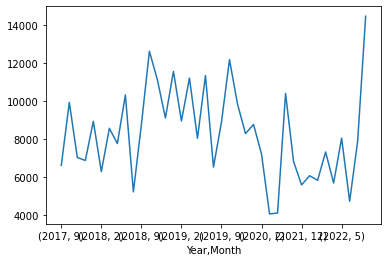

time: 150 ms (started: 2022-11-10 23:35:59 -05:00)


In [17]:
# Average delays per month chart
data_monthly['delay_frequency'].to_csv('../data/output/delays_per_month.csv')
data_monthly['delay_frequency'].plot()

/var/folders/jt/mzncz72n2l53hxv8vgtmr8xw0000gn/T/ipykernel_89168/3224785997.py:3: FutureWarning: ['Occurred_On', 'Incident_Number'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,


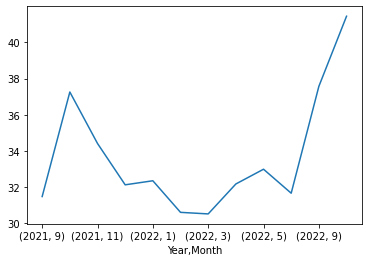

time: 1.69 s (started: 2022-11-10 23:36:00 -05:00)


In [18]:
# Average delay times per month

data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day]).agg(['count', 'sum'])
data_tmp.index.set_names(['Year', 'Month', 'Day'], inplace = True)
# data_tmp.drop(data_tmp[data_tmp['School_Year']['count'] < num_delays_threshold].index, axis = 0, inplace = True)
# display(data_tmp[-60:])
data_tmp = data_tmp['delay_time'].reset_index().groupby(['Year', 'Month']).sum()

# Make data_tmp post covid
data_tmp = data_tmp[(data_tmp.index.get_level_values(0) >= 2021)]
data_tmp = data_tmp[(data_tmp.index.get_level_values(0) >= 2022) |
                    (data_tmp.index.get_level_values(1) > 8)]

(data_tmp['sum']/data_tmp['count']).to_csv('../data/output/delay_time_monthly.csv')
(data_tmp['sum']/data_tmp['count']).plot()

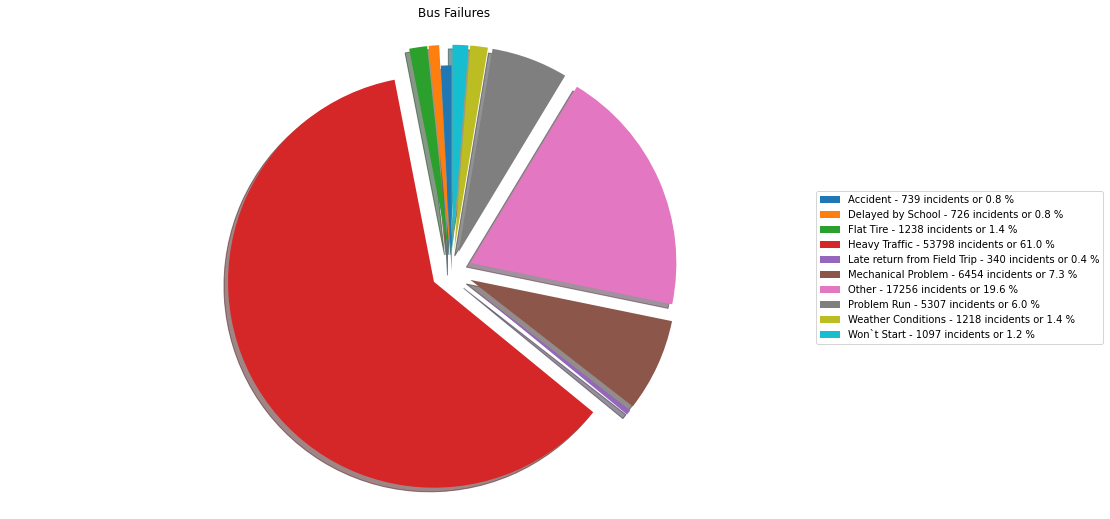

time: 1.33 s (started: 2022-11-10 23:36:03 -05:00)


In [19]:
# Reason for school bus delays

data_tmp = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day]).count()
data_tmp.index.set_names(['Year', 'Month', 'Day'], inplace = True)
# days_to_drop = data_tmp[data_tmp['School_Year'] < num_delays_threshold].index

data_tmp = data.set_index([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day])
data_tmp.index.set_names(['Year', 'Month', 'Day'], inplace = True)
# data_tmp = data_tmp.drop(days_to_drop).sort_index()

# Make data_tmp post covid
data_tmp = data_tmp[(data_tmp.index.get_level_values(0) >= 2021)]

data_tmp = data_tmp[(data_tmp.index.get_level_values(0) >= 2022) |
                    (data_tmp.index.get_level_values(1) > 8)]

#Subset to past 2 months
# data_tmp = data_tmp[(data_tmp.index.get_level_values(0) == 2022 ) & 
#                     (data_tmp.index.get_level_values(1).isin([9, 10]))]


data_tmp.groupby('Reason').count()['School_Year'].to_csv('../data/output/delays_reason_postcovid.csv')
num = data_tmp.groupby('Reason').count()['School_Year']
reason = num.index

percent = []
for i in num:
    percent.append(float(i)*100/float(np.array(num).sum()))

labels = ['{0} - {1} incidents or {2:1.1f} %'.format(i,j,k) for i,j,k in zip(reason, num, percent)]

explode = [0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]
    
# Plot
plt.rcParams["figure.figsize"] = [16,9]

patches, texts = plt.pie(num, shadow=True, explode = explode, startangle=90)

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5))
plt.title("Bus Failures")                  
plt.axis('equal');

In [20]:
# Reasons for delays. Here we can show that Heavy Traffic accounted for 73.8% of delays (above)
# And average delay time due to heavy traffic delays (below)


#Length of delays by reason
data_tmp.groupby('Reason').mean()['delay_time'].to_csv('../data/output/average_delayTime_byType.csv')
data_tmp.groupby('Reason').mean()['delay_time']

Reason
Accident                       42.364005
Delayed by School              25.995179
Flat Tire                      21.031906
Heavy Traffic                  34.969785
Late return from Field Trip    33.923529
Mechanical Problem             24.362798
Other                          36.906033
Problem Run                    45.785755
Weather Conditions             33.431856
Won`t Start                    15.254786
Name: delay_time, dtype: float64

time: 26.8 ms (started: 2022-11-10 23:36:05 -05:00)


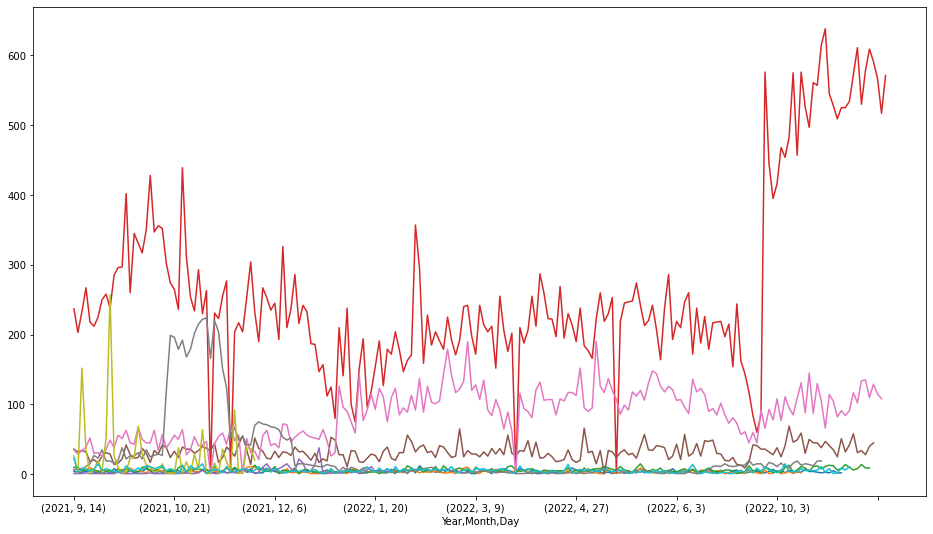

time: 551 ms (started: 2022-11-10 23:36:05 -05:00)


In [21]:
# Reasons for delays over time

data_tmp.reset_index().groupby(['Reason', 'Year', 'Month', 'Day']).count()['School_Year'].to_csv('../data/output/dailyDelays_by_reason.csv')
reasons_for_delays = data_tmp.reset_index().groupby(['Reason', 'Year', 'Month', 'Day']).count()['School_Year'].reset_index(0)

for i in reasons_for_delays['Reason'].unique():
    reasons_for_delays[reasons_for_delays['Reason'] == i]['School_Year'].plot()

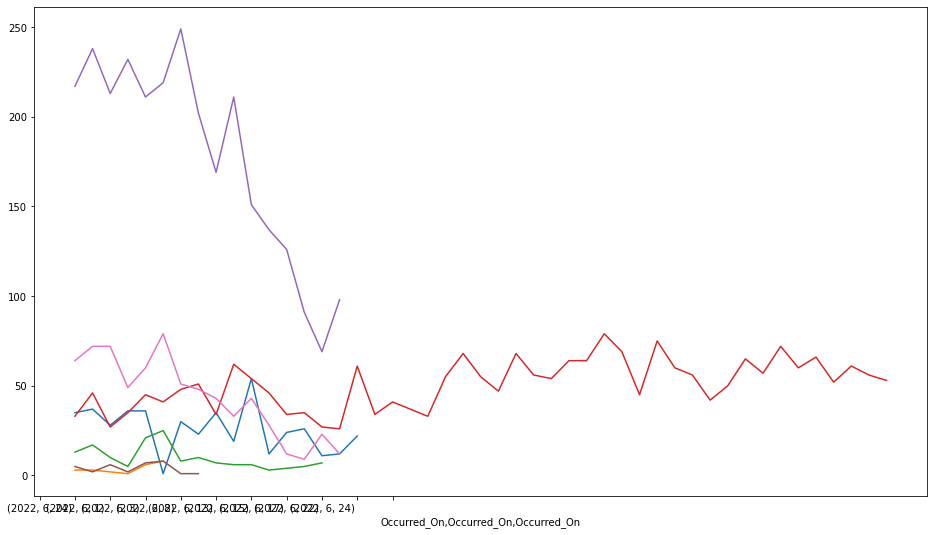

time: 284 ms (started: 2022-11-10 23:36:06 -05:00)


In [22]:
d = data_orig[(data_orig['Occurred_On'].dt.month > 5) & (data_orig['Occurred_On'].dt.year > 2021)]
x = d.groupby(['Run_Type', d['Occurred_On'].dt.year, d['Occurred_On'].dt.month, d['Occurred_On'].dt.day]).count().reset_index(0)
x[['Run_Type', 'School_Year']].to_csv('../data/output/no_more_runType_classification.csv')

for i in x['Run_Type'].unique():
    x[x['Run_Type'] == i]['School_Year'].plot()

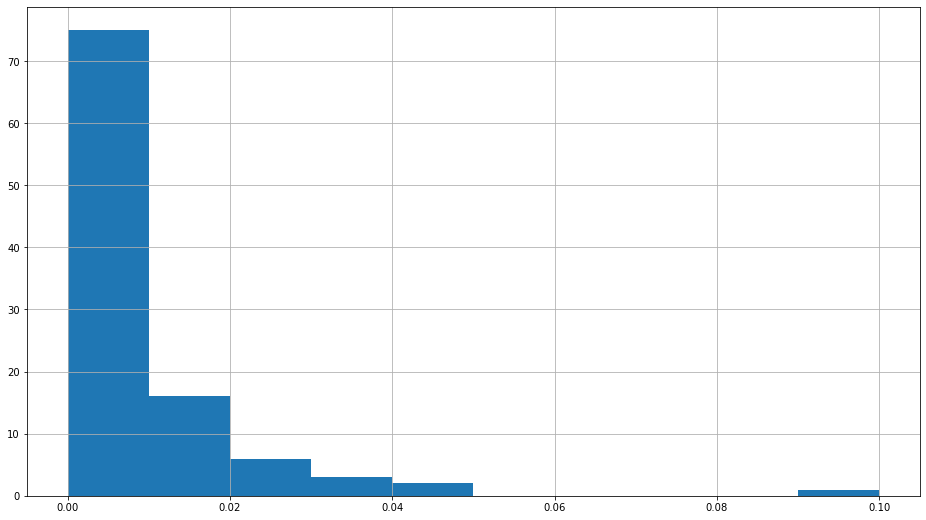

time: 805 ms (started: 2022-11-10 23:36:07 -05:00)


In [23]:
# Won't start, accident/flat-tire

d = data_orig[data_orig['Reason'].isin(['Accident'])].groupby(['Bus_Company_Name']).count()/data_orig.groupby(['Bus_Company_Name']).count()
d.replace(np.nan, 0)['School_Year'].hist()

# Nothing too interesting here that I think we should be follwing up on.